# Tensorflow for Structured Data

This tutorial demonstrates how to classify structured data (e.g. tabular data in a CSV). We will use Keras to define the model, and feature columns as a bridge to map from columns in a CSV to features used to train the model. This tutorial contains complete code to:

    Load a CSV file using Pandas.
    Build an input pipeline to batch and shuffle the rows using tf.data.
    Map from columns in the CSV to features used to train the model using feature columns.
    Build, train, and evaluate a model using Keras.


The Dataset

We will use a small dataset provided by the Cleveland Clinic Foundation for Heart Disease. There are several hundred rows in the CSV. Each row describes a patient, and each column describes an attribute. We will use this information to predict whether a patient has heart disease, which in this dataset is a binary classification task.

Following is a description of this dataset. Notice there are both numeric and categorical columns.

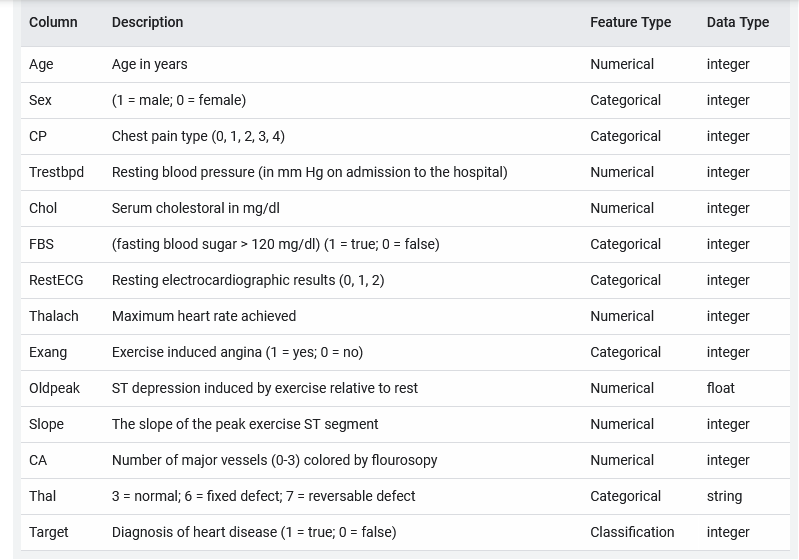

# Load and Split data

In [0]:
! pip install -q sklearn

In [0]:
import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [3]:
URL = 'https://storage.googleapis.com/applied-dl/heart.csv'
dataframe = pd.read_csv(URL)
dataframe.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [4]:
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

193 train examples
49 validation examples
61 test examples


# Create an input pipeline using tf.data

Next, we will wrap the dataframes with tf.data. This will enable us to use feature columns as a bridge to map from the columns in the Pandas dataframe to features used to train the model. If we were working with a very large CSV file (so large that it does not fit into memory), we would use tf.data to read it from disk directly. That is not covered in this tutorial.

In [0]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('target')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds


In [0]:
batch_size = 5 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

# Create Input Pipeline

Now that we have created the input pipeline, let's call it to see the format of the data it returns. We have used a small batch size to keep the output readable.

In [7]:
for feature_batch, label_batch in train_ds.take(1):
    print('Every feature:', list(feature_batch.keys()))
    print('A batch of ages:', feature_batch['age'])
    print('A batch of targets:', label_batch )


Every feature: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
A batch of ages: tf.Tensor([64 60 59 50 57], shape=(5,), dtype=int64)
A batch of targets: tf.Tensor([0 0 0 0 1], shape=(5,), dtype=int64)



We can see that the dataset returns a dictionary of column names (from the dataframe) that map to column values from rows in the dataframe.

# Demonstrate several types of feature column

TensorFlow provides many types of feature columns. In this section, we will create several types of feature columns, and demonstrate how they transform a column from the dataframe.

In [0]:
example_batch = next(iter(train_ds))[0]

In [0]:
# A utility method to create a feature column
# and to transform a batch of data
def demo(feature_column):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch).numpy())


## Numeric Columns

The output of a feature column becomes the input to the model (using the demo function defined above, we will be able to see exactly how each column from the dataframe is transformed).

 A numeric column is the simplest type of column. It is used to represent real valued features. When using this column, your model will receive the column value from the dataframe unchanged.

In [0]:
age = feature_column.numeric_column('age')
demo(age)

## Bucketized columns

Often, you don't want to feed a number directly into the model, but instead split its value into different categories based on numerical ranges. Consider raw data that represents a person's age. 

Instead of representing age as a numeric column, we could split the age into several buckets using a bucketized column. Notice the one-hot values below describe which age range each row matches.

In [0]:
age_buckets = feature_column.bucketized_column(age, boundaries=[10,20,30,40,50,60,70])
demo(age_buckets)


## Categorical columns

In this dataset, thal is represented as a string (e.g. 'fixed', 'normal', or 'reversible'). 

We cannot feed strings directly to a model. Instead, we must first map them to numeric values. 

The categorical vocabulary columns provide a way to represent strings as a one-hot vector (much like you have seen above with age buckets). 

The vocabulary can be passed as a list using categorical_column_with_vocabulary_list, or loaded from a file using categorical_column_with_vocabulary_file.

In [15]:
thal = feature_column.categorical_column_with_vocabulary_list(
      'thal', ['fixed', 'normal', 'reversible'])

thal_one_hot = feature_column.indicator_column(thal)
demo(thal_one_hot)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]


In a more complex dataset, many columns would be categorical (e.g. strings). Feature columns are most valuable when working with categorical data.

Embedding columns

Suppose instead of having just a few possible strings, we have thousands (or more) values per category. 

For a number of reasons, as the number of categories grow large, it becomes infeasible to train a neural network using one-hot encodings. 

We can use an embedding column to overcome this limitation. 

Instead of representing the data as a one-hot vector of many dimensions, an embedding column represents that data as a lower-dimensional, dense vector in which each cell can contain any number, not just 0 or 1. 

The size of the embedding (8, in the example below) is a parameter that must be tuned.

**Key point: using an embedding column is best when a categorical column has many possible values.**

In [0]:
# Notice the input to the embedding column is the categorical column
# we previously created
thal_embedding = feature_column.embedding_column(thal, dimension=8)
demo(thal_embedding)

## Hashed feature columns



Another way to represent a categorical column with a large number of values is to use a categorical_column_with_hash_bucket. 

This feature column calculates a hash value of the input, then selects one of the hash_bucket_size buckets to encode a string. 

When using this column, you do not need to provide the vocabulary, and you can choose to make the number of hash_buckets significantly smaller than the number of actual categories to save space.

**Key point: An important downside of this technique is that there may be collisions in which different strings are mapped to the same bucket. In practice, this can work well for some datasets regardless.**

In [0]:
thal_hashed = feature_column.categorical_column_with_hash_bucket(
      'thal', hash_bucket_size=1000)
demo(feature_column.indicator_column(thal_hashed))

## Crossed feature columns



Combining features into a single feature, better known as feature crosses, enables a model to learn separate weights for each combination of features. 

Here, we will create a new feature that is the cross of age and thal. 

Note that crossed_column does not build the full table of all possible combinations (which could be very large). Instead, it is backed by a hashed_column, so you can choose how large the table is.

In [0]:
crossed_feature = feature_column.crossed_column([age_buckets, thal], hash_bucket_size=1000)
demo(feature_column.indicator_column(crossed_feature))

# Using on our Dataset

We have seen how to use several types of feature columns. Now we will use them to train a model. The goal of this tutorial is to show you the complete code (e.g. mechanics) needed to work with feature columns. We have selected a few columns to train our model below arbitrarily.

**Key point: If your aim is to build an accurate model, try a larger dataset of your own, and think carefully about which features are the most meaningful to include, and how they should be represented.**

In [21]:
dataframe.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [0]:
feature_columns = []

In [0]:
for header in ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'slope', 'ca']:
    feature_columns.append(feature_column.numeric_column(header))

In [26]:
feature_columns

[NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='trestbps', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='chol', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='thalach', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='oldpeak', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='slope', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='ca', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [0]:
age_buckets = feature_column.bucketized_column(age, boundaries=[10,15,20,25,30,35,40,45,50,55,60,65])
feature_columns.append(age_buckets)

In [32]:
print(np.unique(dataframe['thal'].to_numpy()))

['1' '2' 'fixed' 'normal' 'reversible']


In [0]:
# indicator cols
thal = feature_column.categorical_column_with_vocabulary_list('thal', ['fixed', 'normal', 'reversible'])
thal_one_hot = feature_column.indicator_column(thal)
feature_columns.append(thal_one_hot)

In [0]:
# embedding cols
thal_embedding = feature_column.embedding_column(thal, dimension=8)
feature_columns.append(thal_embedding)

In [0]:
# crossed cols
crossed_feature = feature_column.crossed_column([age_buckets, thal], hash_bucket_size=1000)
crossed_feature = feature_column.indicator_column(crossed_feature)
feature_columns.append(crossed_feature)

# Create a feature layer



Now that we have defined our feature columns, we will use a DenseFeatures layer to input them to our Keras model.

In [0]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

Earlier, we used a small batch size to demonstrate how feature columns worked. We create a new input pipeline with a larger batch size.

In [0]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

# Create, compile, and train the model

In [0]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1)
])

In [0]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [0]:
model.fit(train_ds,
          validation_data=val_ds,
          epochs=5)

In [41]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

2/2 [==============================] - 0s 3ms/step - loss: 0.4785 - accuracy: 0.7869
Accuracy 0.7868852615356445


# Note

Key point:
You will typically see best results with deep learning with much larger and more complex datasets. 

When working with a small dataset like this one, we recommend using a decision tree or random forest as a strong baseline. 

The goal of this tutorial is not to train an accurate model, but to demonstrate the mechanics of working with structured data, so you have code to use as a starting point when working with your own datasets in the future.